In [1]:
# dont forget to switch to GPU if possible
google_colab_env = False

In [2]:
if google_colab_env:
    from google.colab import drive
    %tensorflow_version 1.x
    drive.mount('/content/drive')
    !git clone https://github.com/GrzegorzKazana/artificial-music.git

## importing dataset, splitting tracks

In [3]:
import os
import sys
import json
import numpy as np
from scipy import sparse

proj_base_path = ('/content/artificial-music' 
                  if google_colab_env else '../../../')

data_base_path =  ('/content/drive/My Drive/artificial-music/datasets'
                   if google_colab_env else '../../../datasets')

models_base_path =  ('/content/drive/My Drive/artificial-music/pretrained_models' 
                     if google_colab_env else '../../../pretrained_models')

sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_clustered_time'
word_vectors_file = 'meta/_word_vectors_11000_ignore_ratio=0.05.wv'
duration_dict_file = 'meta/durations_dict.json'

word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)
with open(os.path.join(data_base_path, dataset_path, duration_dict_file)) as fp:
    duration_dict = json.load(fp)

tracks_path = os.path.join(data_base_path, dataset_path)
track_paths = [os.path.join(tracks_path, f) for f in os.listdir(tracks_path) if f.endswith('.npz')]

tracks = [sparse.load_npz(p).toarray() for p in track_paths]

for t in tracks: print(t.shape, end='')

(253, 152)(343, 152)(487, 152)(121, 152)(917, 152)(121, 152)(1002, 152)(1002, 152)(121, 152)(917, 152)(487, 152)(343, 152)(253, 152)(551, 152)(551, 152)(487, 152)(317, 152)(121, 152)(917, 152)(121, 152)(1002, 152)(1002, 152)(917, 152)(121, 152)(121, 152)(317, 152)(487, 152)(551, 152)(228, 152)(487, 152)(121, 152)(121, 152)(917, 152)(917, 152)(1002, 152)(1002, 152)(317, 152)(917, 152)(917, 152)(121, 152)(917, 152)(121, 152)(487, 152)(228, 152)(487, 152)(917, 152)(121, 152)(121, 152)(317, 152)(317, 152)(1002, 152)(917, 152)(121, 152)(917, 152)(121, 152)(228, 152)(487, 152)(487, 152)(389, 152)(228, 152)(317, 152)(389, 152)(343, 152)(389, 152)(317, 152)(228, 152)(389, 152)(487, 152)(228, 152)(389, 152)(228, 152)(253, 152)(343, 152)(343, 152)(389, 152)(253, 152)(228, 152)(389, 152)(487, 152)(228, 152)(121, 152)(487, 152)(551, 152)(253, 152)(389, 152)(228, 152)(487, 152)(343, 152)(343, 152)(1002, 152)(389, 152)(1002, 152)(389, 152)(343, 152)(228, 152)(317, 152)(228, 152)(389, 152)(551, 152)(

### prepare dataset generator

In [4]:
def dataset_gen(tracks, window_size_range=(20, 300), batch_size=16):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    max_window_size = min([len(t) for t in tracks]) - 3
    while True:
        window_size = np.random.randint(window_size_range[0], min(max_window_size, window_size_range[1]))
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(tracks, (10, 50), 5))
x.shape, y.shape

((5, 12, 152), (5, 12, 152))

## Setting up model

In [5]:
from tensorflow import keras as K

NOTES_INPUT_SIZE = 128
DURATION_INPUT_SIZE = 24

MAIN_LSTM_SIZE = 256
MAIN_DENSE_SIZE = 128

NOTES_LSTM_SIZE = 128
DURATION_LSTM_SIZE = 32

NOTES_OUTPUT_DENSE = 128
DURATION_OUTPUT_DENSE = 32

NOTES_OUTPUT_SIZE = NOTES_INPUT_SIZE
DURATION_OUTPUT_SIZE = DURATION_INPUT_SIZE

BATCH_SIZE = 16
WINDOW_SIZE_RANGE = (10, 25)

NOTES_INPUT_SHAPE = (None, NOTES_INPUT_SIZE)
DURATION_INPUT_SHAPE = (None, DURATION_INPUT_SIZE)
# None allows for variable seq_length between batches

NOTES_INPUT_NAME = 'notes_input'
DURATION_INPUT_NAME = 'duration_input'
NOTES_OUTPUT_NAME = 'notes_output'
DURATION_OUTPUT_NAME = 'duration_output'

#### load existing model

In [ ]:
# or load saved model
model_path = 'lstm_lstm/embedded_16_128_stacked_32/embedded_16_128_stacked_32md_e200_t2019-10-09T09_59_31_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

#### or create new one

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, Input, Concatenate
rnn_layer = CuDNNLSTM if google_colab_env else LSTM

x1 = Input(NOTES_INPUT_SHAPE, name=NOTES_INPUT_NAME)
x2 = Input(DURATION_INPUT_SHAPE, name=DURATION_INPUT_NAME)

h1 = Concatenate()([x1, x2])
h2 = rnn_layer(MAIN_LSTM_SIZE, return_sequences=True)(h1)
h3 = Dense(MAIN_DENSE_SIZE)(h2)

g1 = rnn_layer(NOTES_LSTM_SIZE, return_sequences=True)(h3)
g2 = Dense(NOTES_OUTPUT_DENSE)(g1)
y1 = Dense(NOTES_OUTPUT_SIZE, name=NOTES_OUTPUT_NAME, activation='sigmoid')(g2)

i1 = rnn_layer(DURATION_LSTM_SIZE, return_sequences=True)(h3)
i2 = Dense(DURATION_OUTPUT_DENSE)(i1)
y2 = Dense(DURATION_OUTPUT_SIZE, name=DURATION_OUTPUT_NAME, activation='softmax')(i2)

model = Model(inputs=[x1, x2], outputs=[y1, y2])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
notes_input (InputLayer)        [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     [(None, None, 24)]   0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 152)    0           notes_input[0][0]                
                                                                 duration_input[0][0]             
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 256)    418816      concatenate_1[0][0]        

In [8]:
losses = {
    NOTES_OUTPUT_NAME: 'binary_crossentropy',
    DURATION_OUTPUT_NAME: 'categorical_crossentropy',
}

metrics = {
    NOTES_OUTPUT_NAME: ['binary_crossentropy'],
    DURATION_OUTPUT_NAME: ['categorical_accuracy'],
}

# maybe diffrent weights for outputs???

model.compile(
    loss=losses,
    optimizer='adam', 
    metrics=metrics,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### define training callbacks

In [14]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback

# logging callback
logging_path = 'lstm'
experiment_name = f'clustered_time_{MAIN_LSTM_SIZE}'
experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
os.makedirs(experiment_path, exist_ok=True)
print(f'saving checkpoints and logs to {experiment_path}')

# logging disabled for now
log_callback = ModelAndLogSavingCallback(model, experiment_path, save_log_only=True)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.sparse_clustered_time_generating_seeds import seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.sparse_notes_classified_time.np2mid import np2sparse
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track

SEED_LENGTH = 10
GENERATED_SEQ_LENGTH = 50
GENERATING_WINDOW_SIZE = 25
METHOD = 'band_noise_seed'

# seed_generator = lambda: seed_generators[METHOD](
#     SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=BATCH_SIZE)

def seed_generator():
    s = seed_generators[METHOD](
        SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=BATCH_SIZE)
#     print(s.shape, s)
    return s

# sample_generator = lambda model, seed: recurrent_generate(
#     model, 
#     seed, 
#     GENERATED_SEQ_LENGTH, 
#     GENERATING_WINDOW_SIZE, 
#     is_binary=True,
#     transform_input=lambda x: (x[:, :, :NOTES_INPUT_SIZE], x[:, :, NOTES_INPUT_SIZE:]),
#     transform_output=lambda args: np.concatenate(args, axis=2),
# )

def sample_generator(model, seed):
    r = recurrent_generate(
        model, 
        seed, 
        GENERATED_SEQ_LENGTH, 
        GENERATING_WINDOW_SIZE, 
        is_binary=True,
        transform_input=lambda x: (x[:, :, :NOTES_INPUT_SIZE], x[:, :, NOTES_INPUT_SIZE:]),
        transform_output=lambda args: np.concatenate(args, axis=2),
    )
#     print(r.shape, r)
    return r.round()

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    lambda batch_of_samples: [
        np2sparse(
            s[:, :NOTES_INPUT_SIZE],
            s[:, NOTES_INPUT_SIZE:],
            duration_dict,
            ppq=6,
        ) for s in batch_of_samples]
)

print(f'generating sequences of {GENERATED_SEQ_LENGTH} using {METHOD}')

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)

saving checkpoints and logs to ../../../pretrained_models/lstm/clustered_time_256
restored archived logs
generating sequences of 50 using band_noise_seed


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint(
    os.path.join(experiment_path, 'model.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-2,
    patience=10
)

#### training

In [10]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

def dataset_gen_split_inout(X, window_size_range, batch_size):
    gen = dataset_gen(X, window_size_range, batch_size)
    while True:
        x, y = next(gen)
        x_split = {
            NOTES_INPUT_NAME: x[:, :, :NOTES_INPUT_SIZE],
            DURATION_INPUT_NAME: x[:, :, NOTES_INPUT_SIZE:],
        }
        y_split = {
            NOTES_OUTPUT_NAME: y[:, :, :NOTES_INPUT_SIZE],
            DURATION_OUTPUT_NAME: y[:, :, NOTES_INPUT_SIZE:],
        }
        yield x_split, y_split

# reserving last 25 notes for validation
tracks_train = [t[:-25] for t in tracks]
tracks_val = [t[-25:] for t in tracks]

data_gen = dataset_gen_split_inout(tracks_train, WINDOW_SIZE_RANGE, BATCH_SIZE)
test_gen = dataset_gen_split_inout(tracks_val, WINDOW_SIZE_RANGE, BATCH_SIZE)

Epoch 1/10
  97/1000 [=>............................] - ETA: 8s - loss: 1.0498 - notes_output_loss: 0.0715 - duration_output_loss: 0.9782 - notes_output_binary_crossentropy: 0.0712 - duration_output_categorical_accuracy: 0.7498

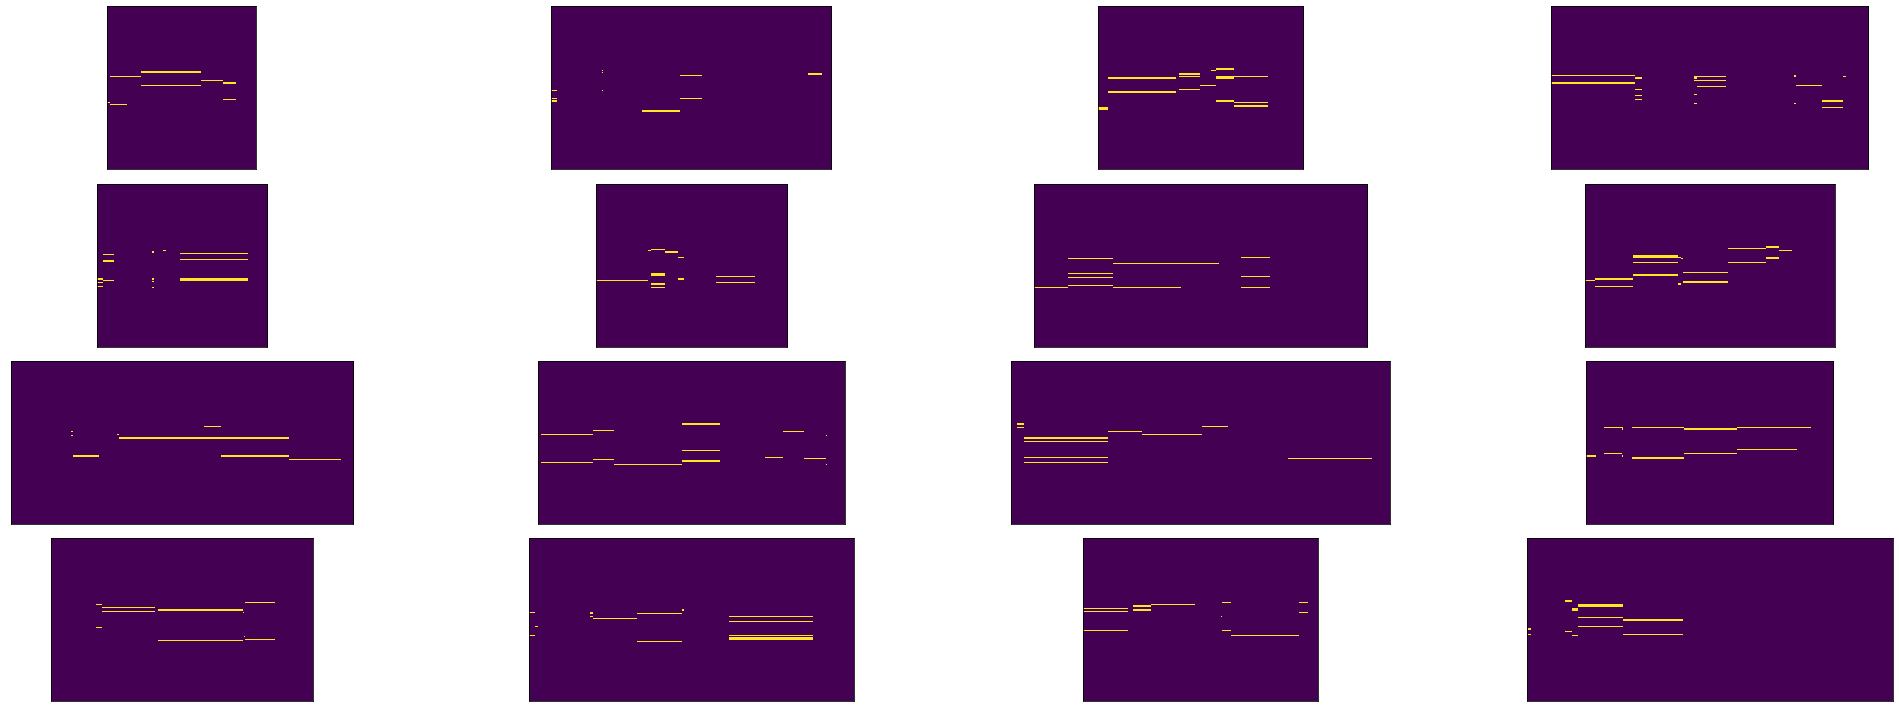

1000/1000 [==============================] - 50s 50ms/step - loss: 0.7473 - notes_output_loss: 0.0697 - duration_output_loss: 0.6775 - notes_output_binary_crossentropy: 0.0698 - duration_output_categorical_accuracy: 0.7893 - val_loss: 1.0485 - val_notes_output_loss: 0.0712 - val_duration_output_loss: 0.9772 - val_notes_output_binary_crossentropy: 0.0708 - val_duration_output_categorical_accuracy: 0.7504
Epoch 2/10
 100/1000 [==>...........................] - ETA: 10s - loss: 1.0206 - notes_output_loss: 0.0687 - duration_output_loss: 0.9519 - notes_output_binary_crossentropy: 0.0683 - duration_output_categorical_accuracy: 0.7739

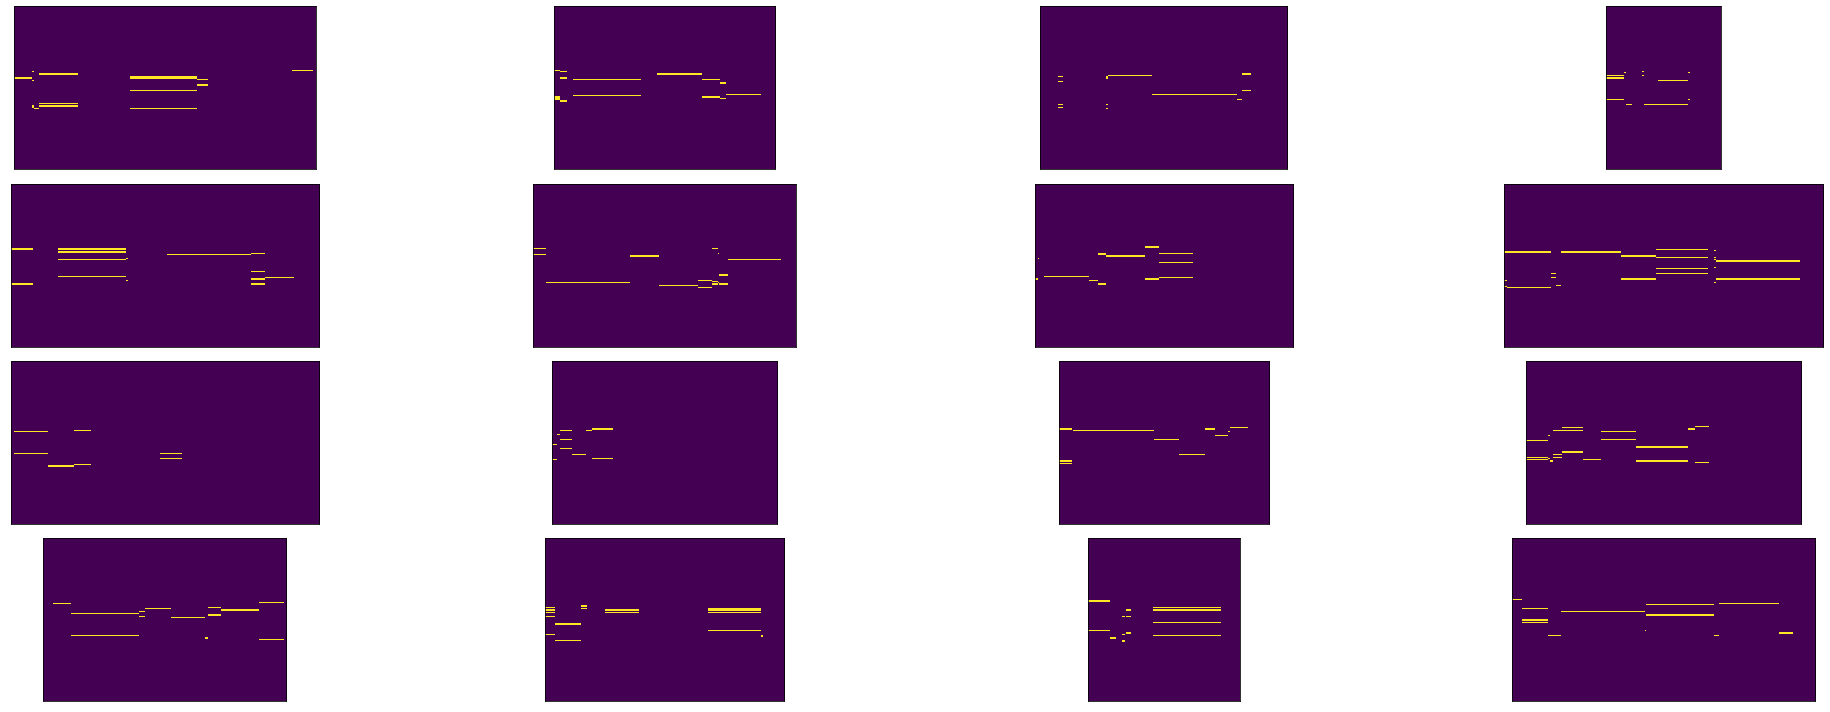

1000/1000 [==============================] - 49s 49ms/step - loss: 0.4361 - notes_output_loss: 0.0666 - duration_output_loss: 0.3695 - notes_output_binary_crossentropy: 0.0666 - duration_output_categorical_accuracy: 0.8885 - val_loss: 1.0206 - val_notes_output_loss: 0.0687 - val_duration_output_loss: 0.9519 - val_notes_output_binary_crossentropy: 0.0683 - val_duration_output_categorical_accuracy: 0.7739
Epoch 3/10
  98/1000 [=>............................] - ETA: 8s - loss: 1.1159 - notes_output_loss: 0.0688 - duration_output_loss: 1.0471 - notes_output_binary_crossentropy: 0.0686 - duration_output_categorical_accuracy: 0.7655

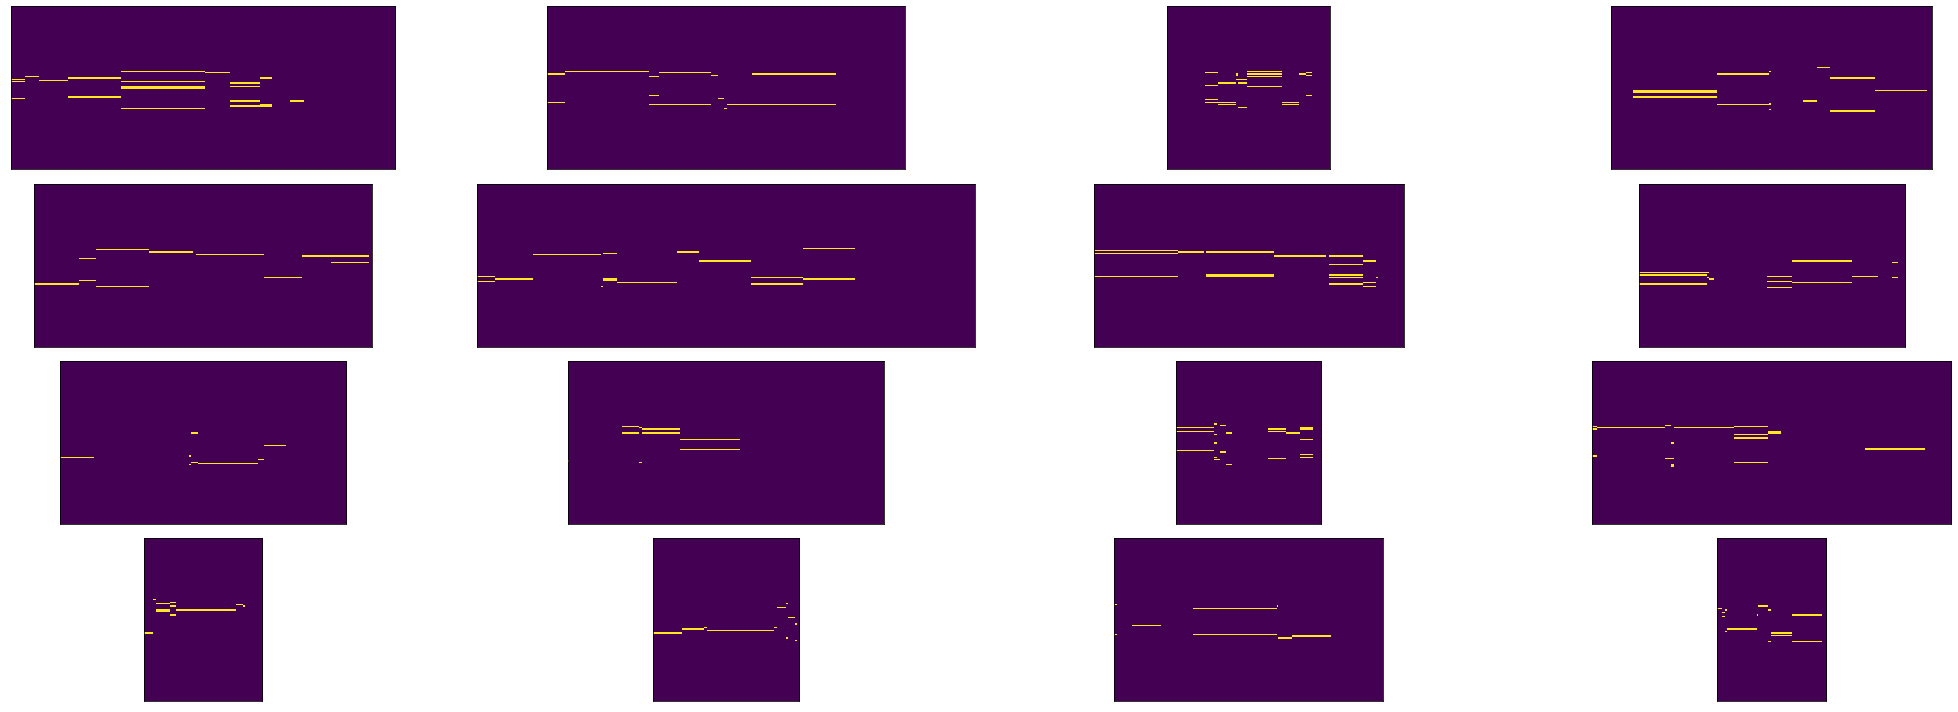

1000/1000 [==============================] - 54s 54ms/step - loss: 0.3444 - notes_output_loss: 0.0652 - duration_output_loss: 0.2792 - notes_output_binary_crossentropy: 0.0652 - duration_output_categorical_accuracy: 0.9134 - val_loss: 1.1240 - val_notes_output_loss: 0.0688 - val_duration_output_loss: 1.0552 - val_notes_output_binary_crossentropy: 0.0686 - val_duration_output_categorical_accuracy: 0.7635
Epoch 4/10
  98/1000 [=>............................] - ETA: 8s - loss: 1.2388 - notes_output_loss: 0.0669 - duration_output_loss: 1.1719 - notes_output_binary_crossentropy: 0.0667 - duration_output_categorical_accuracy: 0.7616

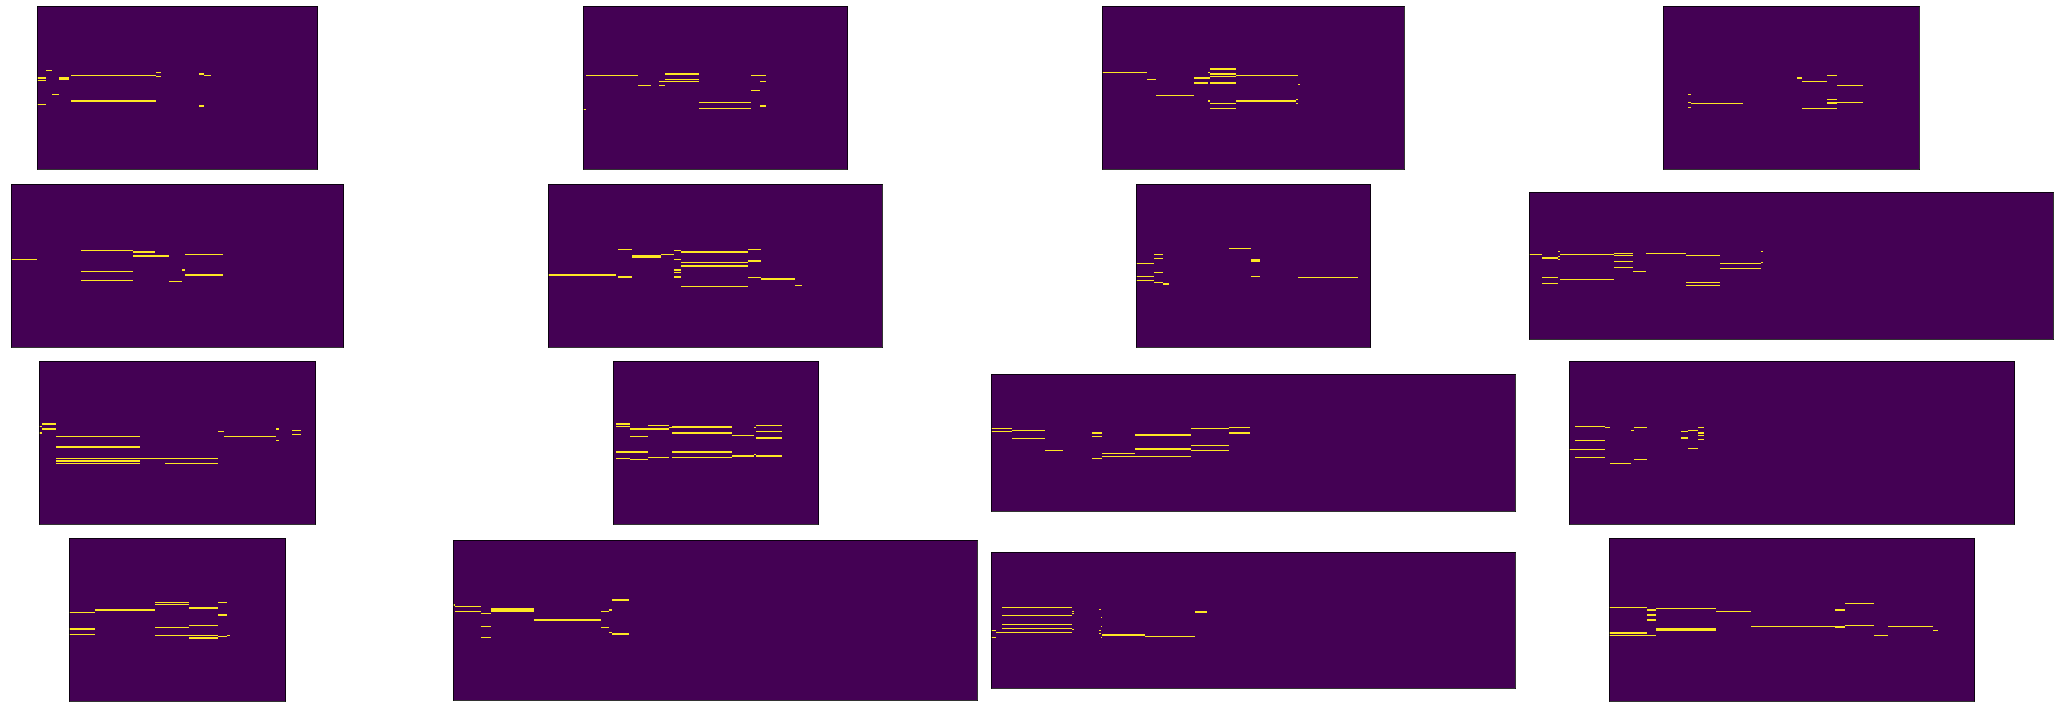

1000/1000 [==============================] - 53s 53ms/step - loss: 0.3019 - notes_output_loss: 0.0636 - duration_output_loss: 0.2384 - notes_output_binary_crossentropy: 0.0636 - duration_output_categorical_accuracy: 0.9240 - val_loss: 1.2348 - val_notes_output_loss: 0.0668 - val_duration_output_loss: 1.1681 - val_notes_output_binary_crossentropy: 0.0665 - val_duration_output_categorical_accuracy: 0.7619
Epoch 5/10
  99/1000 [=>............................] - ETA: 10s - loss: 1.1732 - notes_output_loss: 0.0663 - duration_output_loss: 1.1069 - notes_output_binary_crossentropy: 0.0660 - duration_output_categorical_accuracy: 0.7753

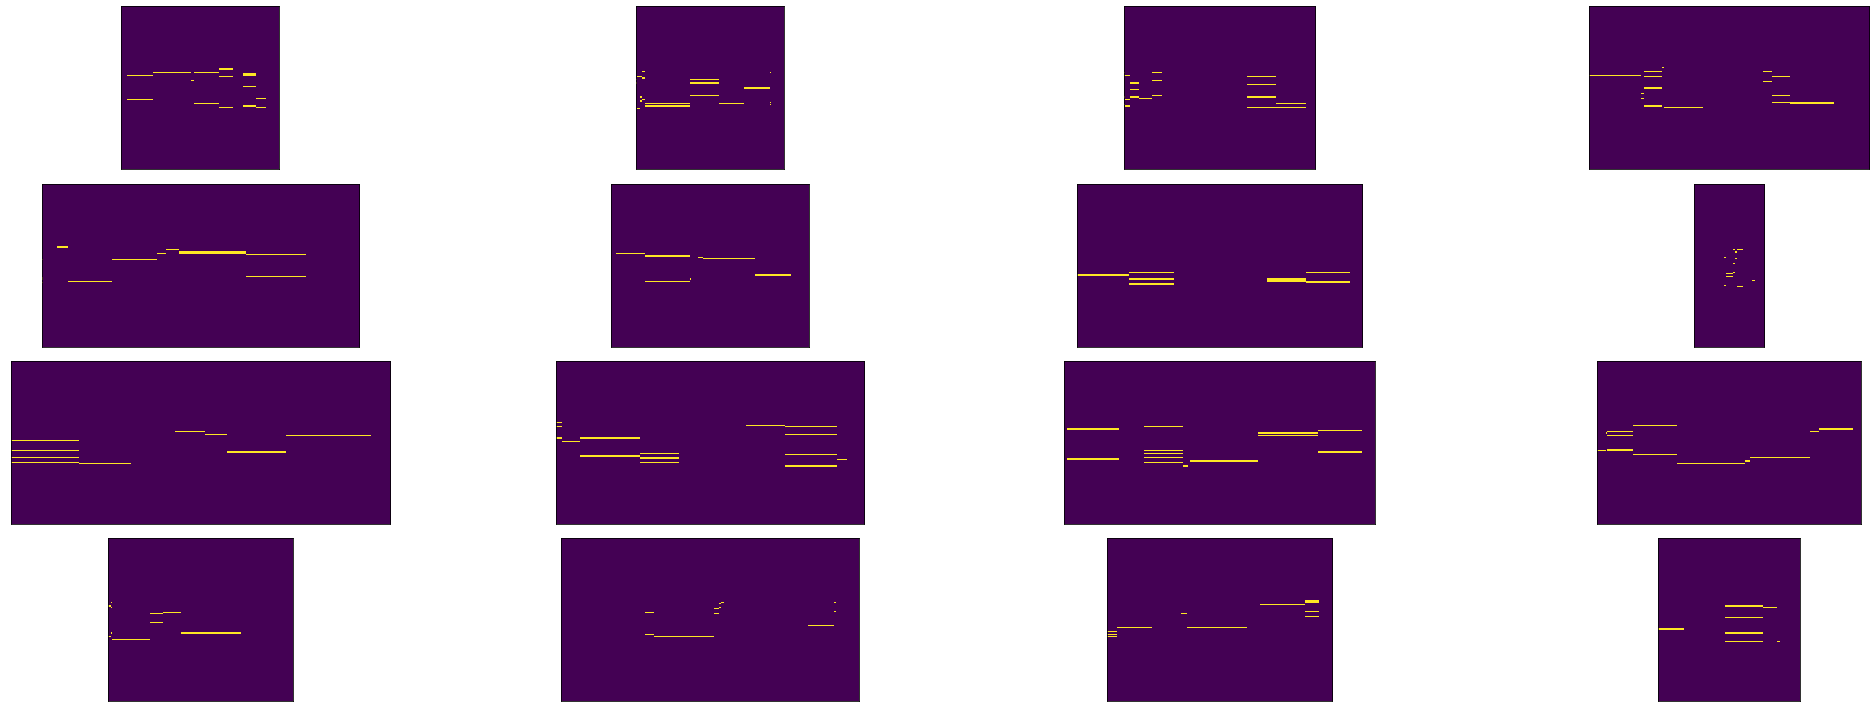

1000/1000 [==============================] - 49s 49ms/step - loss: 0.2872 - notes_output_loss: 0.0624 - duration_output_loss: 0.2248 - notes_output_binary_crossentropy: 0.0623 - duration_output_categorical_accuracy: 0.9279 - val_loss: 1.1721 - val_notes_output_loss: 0.0664 - val_duration_output_loss: 1.1057 - val_notes_output_binary_crossentropy: 0.0660 - val_duration_output_categorical_accuracy: 0.7755
Epoch 6/10
  95/1000 [=>............................] - ETA: 7s - loss: 1.3064 - notes_output_loss: 0.0659 - duration_output_loss: 1.2406 - notes_output_binary_crossentropy: 0.0659 - duration_output_categorical_accuracy: 0.7548

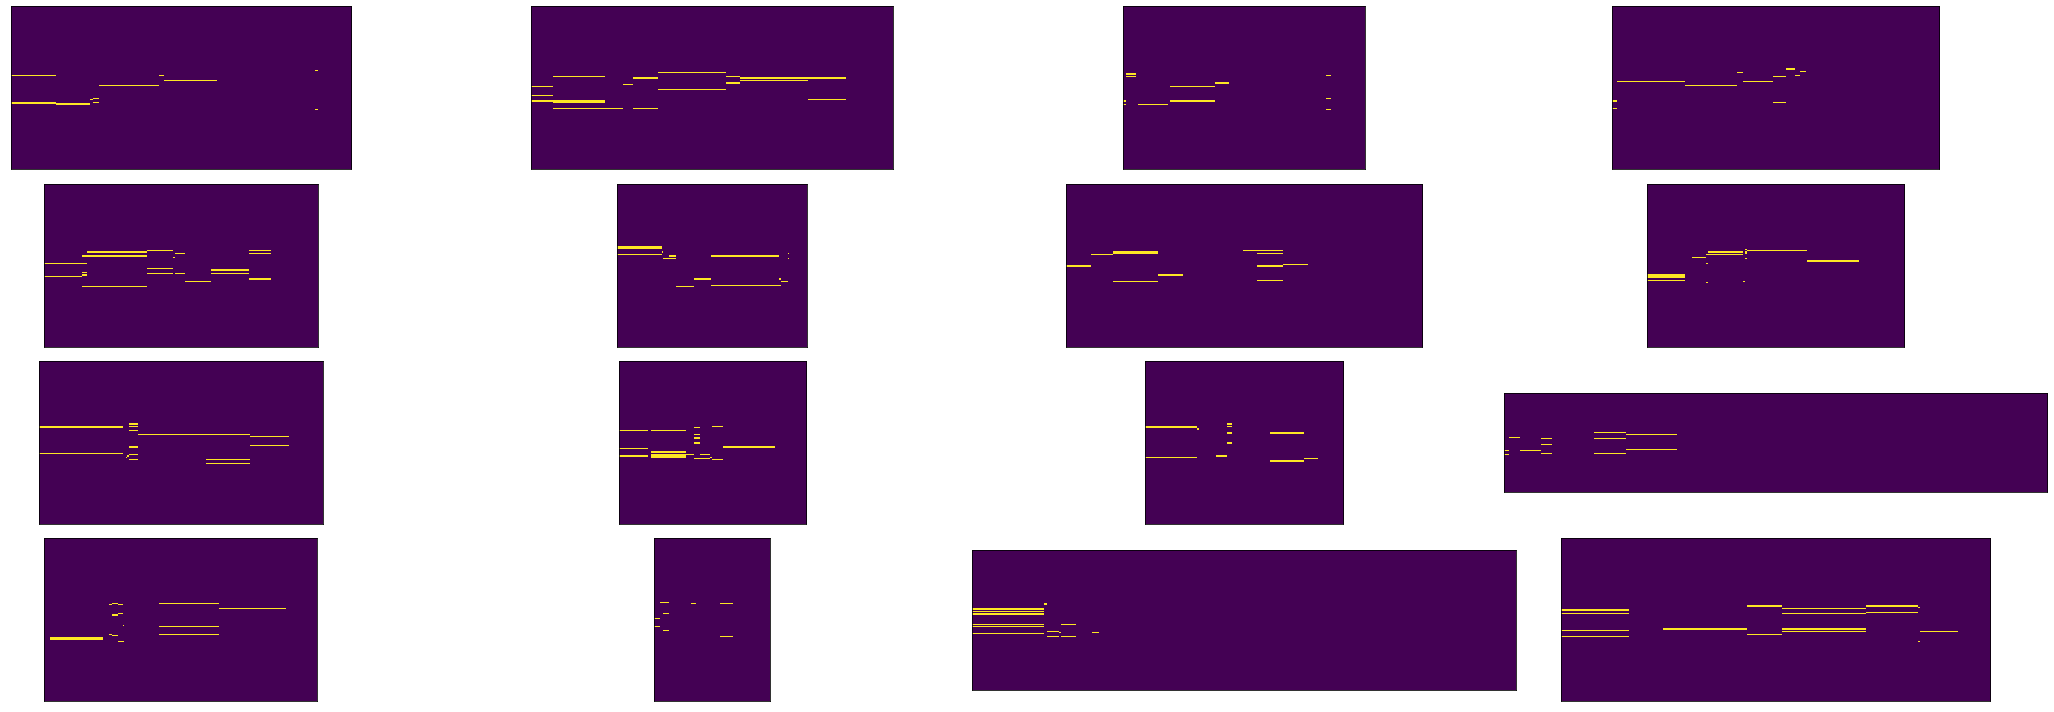

1000/1000 [==============================] - 50s 50ms/step - loss: 0.2655 - notes_output_loss: 0.0612 - duration_output_loss: 0.2044 - notes_output_binary_crossentropy: 0.0611 - duration_output_categorical_accuracy: 0.9336 - val_loss: 1.3028 - val_notes_output_loss: 0.0660 - val_duration_output_loss: 1.2367 - val_notes_output_binary_crossentropy: 0.0661 - val_duration_output_categorical_accuracy: 0.7565
Epoch 7/10
  99/1000 [=>............................] - ETA: 8s - loss: 1.3262 - notes_output_loss: 0.0621 - duration_output_loss: 1.2640 - notes_output_binary_crossentropy: 0.0621 - duration_output_categorical_accuracy: 0.7599

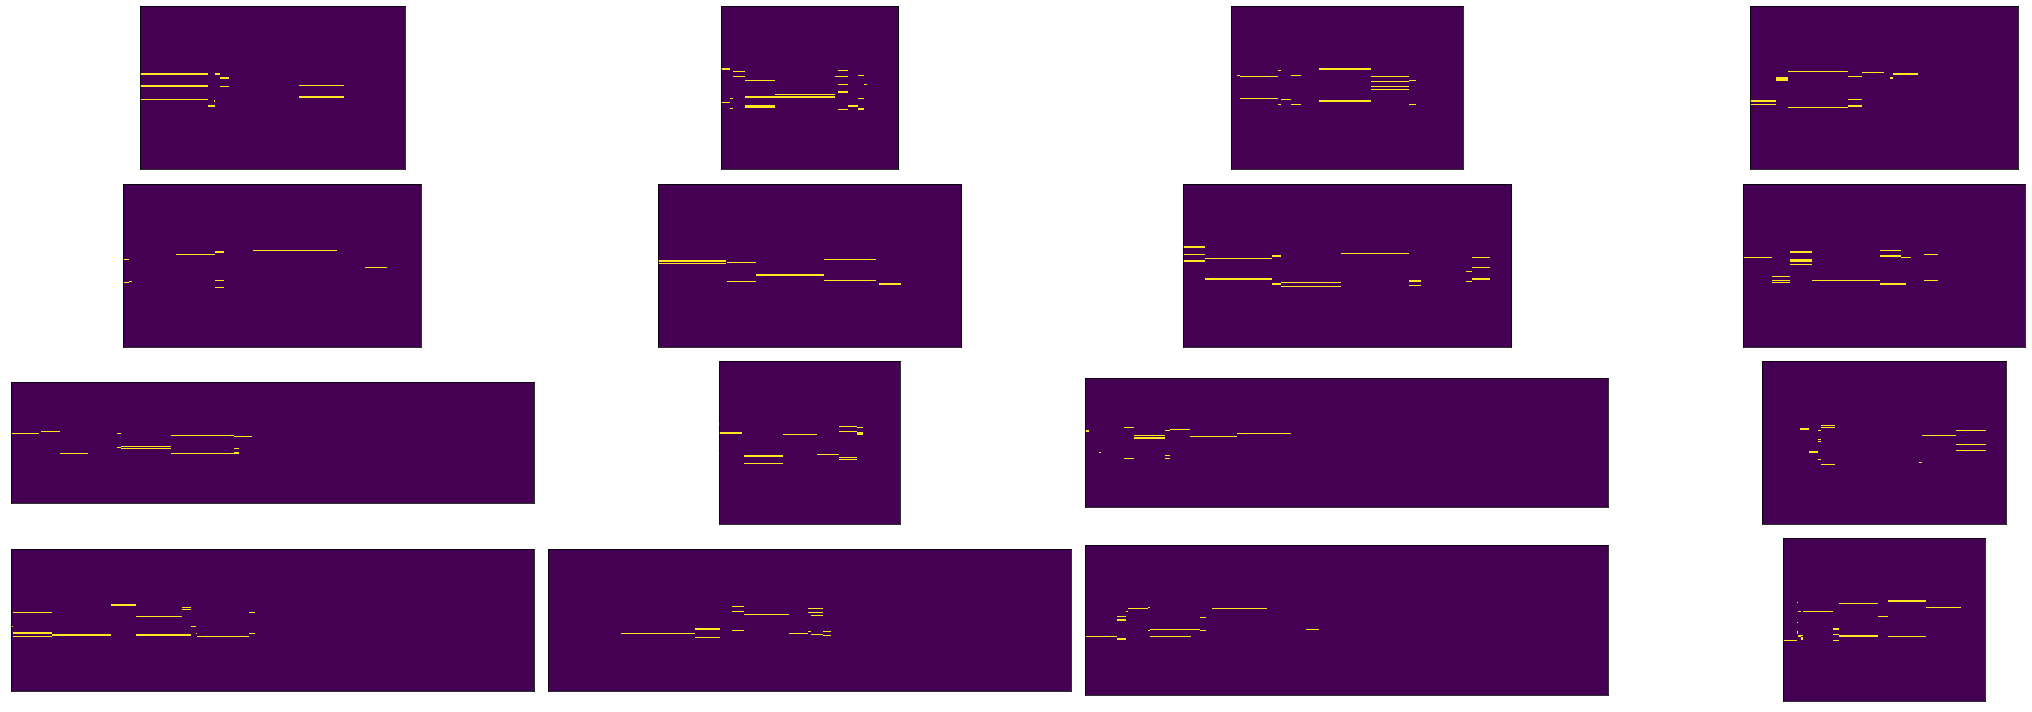

1000/1000 [==============================] - 48s 48ms/step - loss: 0.2590 - notes_output_loss: 0.0598 - duration_output_loss: 0.1993 - notes_output_binary_crossentropy: 0.0598 - duration_output_categorical_accuracy: 0.9350 - val_loss: 1.3308 - val_notes_output_loss: 0.0621 - val_duration_output_loss: 1.2687 - val_notes_output_binary_crossentropy: 0.0621 - val_duration_output_categorical_accuracy: 0.7592
Epoch 8/10
  97/1000 [=>............................] - ETA: 7s - loss: 1.3784 - notes_output_loss: 0.0612 - duration_output_loss: 1.3172 - notes_output_binary_crossentropy: 0.0610 - duration_output_categorical_accuracy: 0.7462

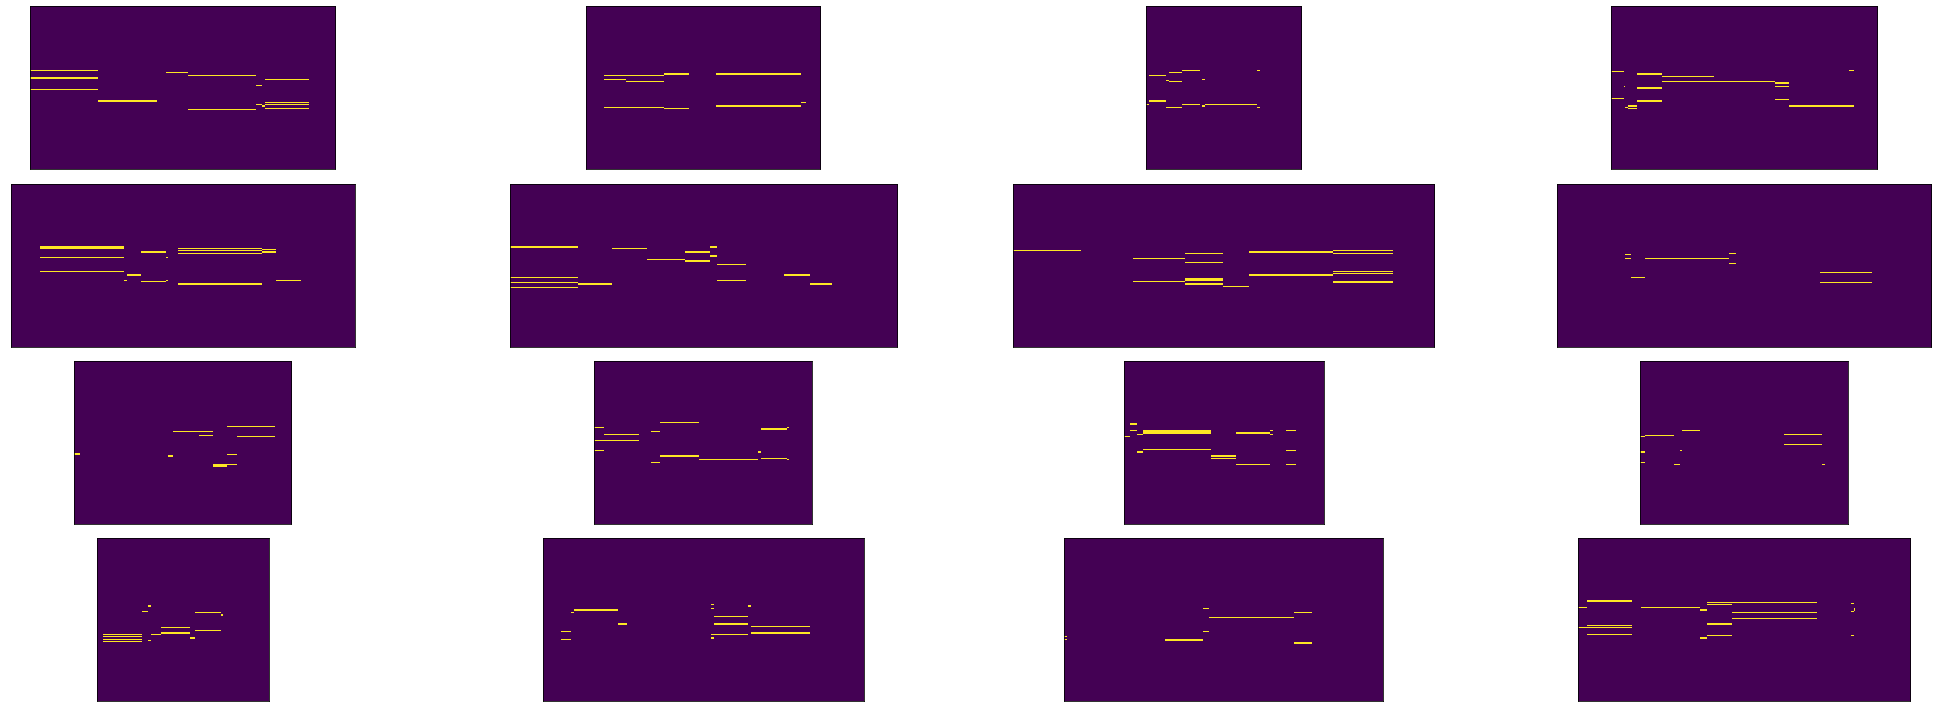

1000/1000 [==============================] - 46s 46ms/step - loss: 0.2447 - notes_output_loss: 0.0575 - duration_output_loss: 0.1872 - notes_output_binary_crossentropy: 0.0574 - duration_output_categorical_accuracy: 0.9379 - val_loss: 1.3847 - val_notes_output_loss: 0.0613 - val_duration_output_loss: 1.3234 - val_notes_output_binary_crossentropy: 0.0611 - val_duration_output_categorical_accuracy: 0.7452
Epoch 9/10
  98/1000 [=>............................] - ETA: 8s - loss: 1.3677 - notes_output_loss: 0.0604 - duration_output_loss: 1.3073 - notes_output_binary_crossentropy: 0.0602 - duration_output_categorical_accuracy: 0.7686

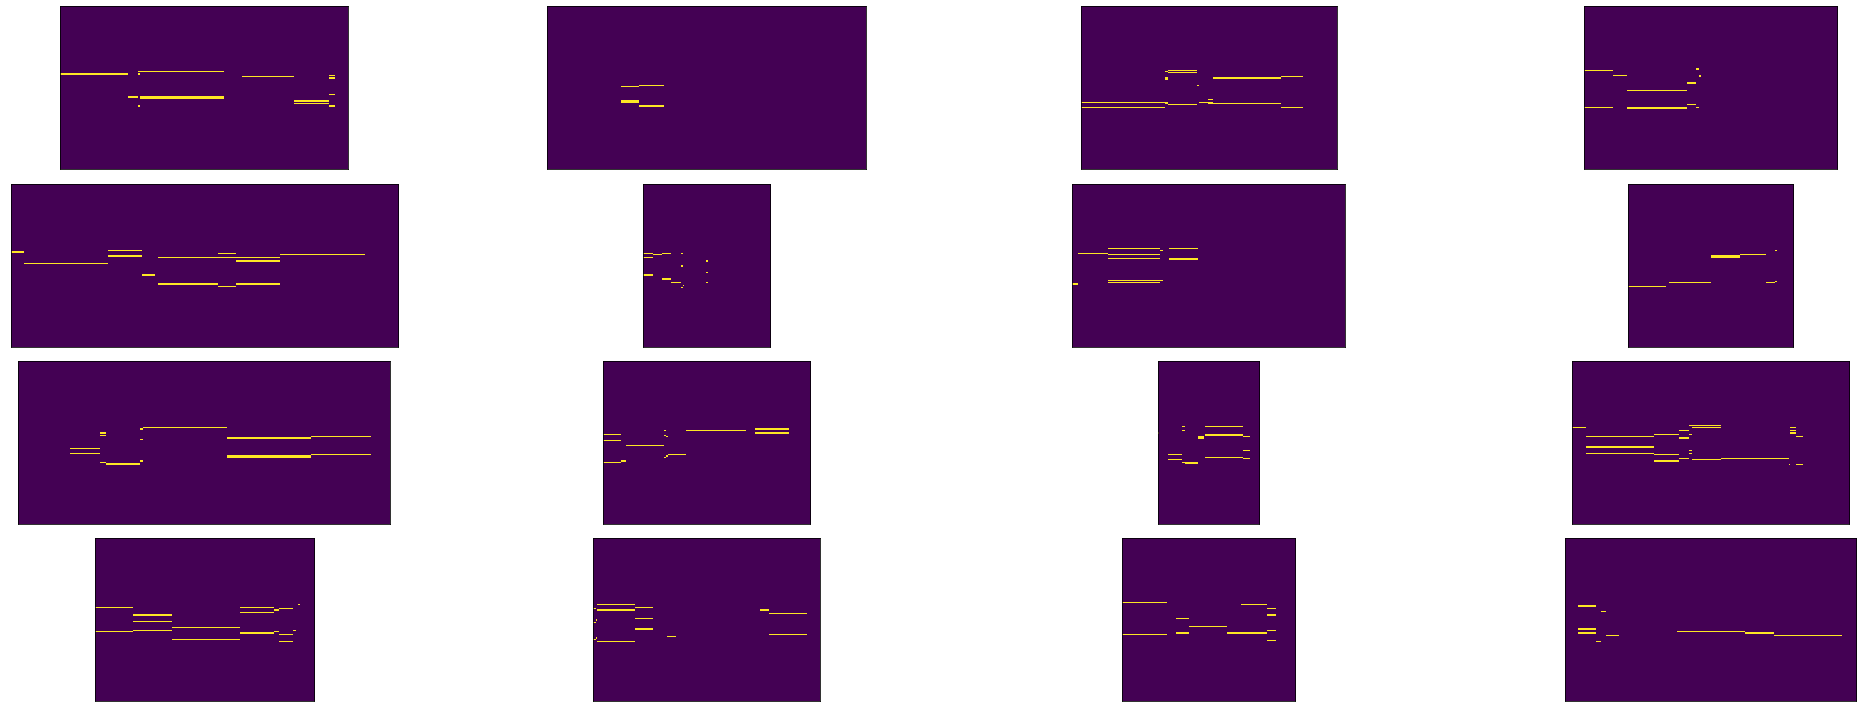

1000/1000 [==============================] - 50s 50ms/step - loss: 0.2348 - notes_output_loss: 0.0558 - duration_output_loss: 0.1790 - notes_output_binary_crossentropy: 0.0556 - duration_output_categorical_accuracy: 0.9407 - val_loss: 1.3699 - val_notes_output_loss: 0.0605 - val_duration_output_loss: 1.3094 - val_notes_output_binary_crossentropy: 0.0603 - val_duration_output_categorical_accuracy: 0.7681
Epoch 10/10
  95/1000 [=>............................] - ETA: 7s - loss: 1.2794 - notes_output_loss: 0.0580 - duration_output_loss: 1.2214 - notes_output_binary_crossentropy: 0.0580 - duration_output_categorical_accuracy: 0.7781

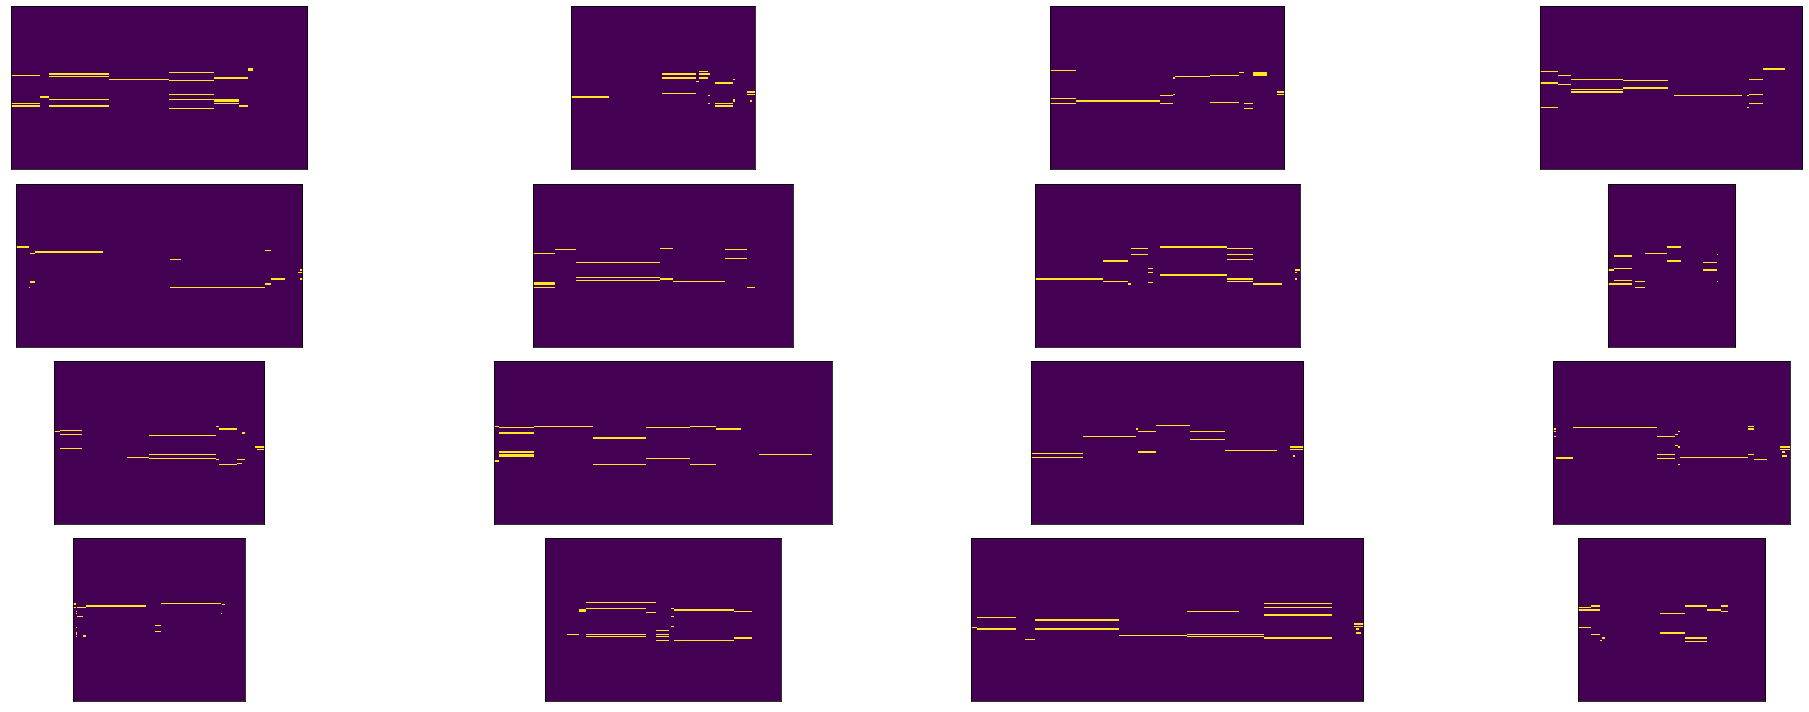

1000/1000 [==============================] - 47s 47ms/step - loss: 0.2265 - notes_output_loss: 0.0545 - duration_output_loss: 0.1720 - notes_output_binary_crossentropy: 0.0543 - duration_output_categorical_accuracy: 0.9432 - val_loss: 1.2729 - val_notes_output_loss: 0.0580 - val_duration_output_loss: 1.2149 - val_notes_output_binary_crossentropy: 0.0579 - val_duration_output_categorical_accuracy: 0.7791


In [16]:
EPOCHS = 10
STEPS_PER_EPOCH = 1000
TEST_STEPS = 100

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[log_callback, gen_callback, ] #mc, es]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS

### convert gpu model to cpu

In [ ]:
model_path = 'lstm/embedded_16_128md_e1_t2019-10-08T18:06:50.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

In [ ]:
from src.training.common.CUDNNLSTM_LSTM import cudnnlstm_to_lstm

cpu_model = cudnnlstm_to_lstm(model)
cpu_model.compile(
    loss='mean_squared_error',
    optimizer='adam', 
    metrics=["mean_squared_error"],
)

K.models.save_model(cpu_model, os.path.join(models_base_path, model_path).replace('.h5', '_cpu.h5'))